### Learning about autoencoders in Tensorflow

In [ ]:
pip install tensorflow

In [6]:
## Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

#### Image Reconstruction

In [28]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [29]:
type(x_train)

numpy.ndarray

In [30]:
type(x_test)

numpy.ndarray

In [30]:
latent_dim = 64 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(784, activation='sigmoid'),
          layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train, epochs = 10, shuffle = True, validation_data = (x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0238 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0

In [31]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________


In [32]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 784)               50960     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
_________________________________________________________________


In [33]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

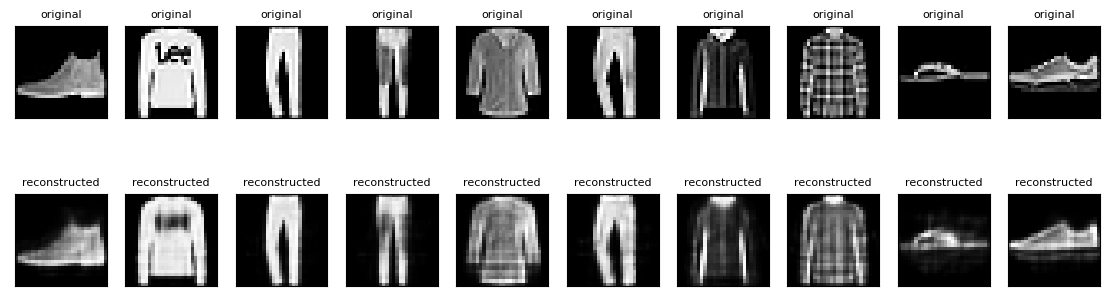

In [36]:
n = 10
plt.figure(figsize=(14, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original", fontsize = 8)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed", fontsize = 8)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Image De-Noising

In [7]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


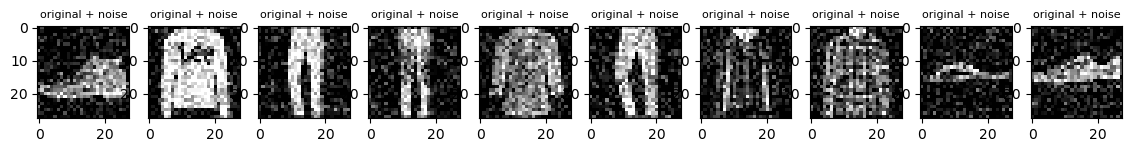

In [8]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

n = 10
plt.figure(figsize=(14, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise", fontsize = 8)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [6]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, data_format = 'channels_last'),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2, data_format = 'channels_last')])

        self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same', data_format = 'channels_last'),
        layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same',  data_format = 'channels_last'),
        layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same',  data_format = 'channels_last')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train_noisy, x_train, epochs = 3, shuffle = True, validation_data = (x_test_noisy, x_test))

Epoch 1/3
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0175 - val_loss: 0.0093
Epoch 2/3
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 3/3
1875/1875 [==============================] - 74s 39ms/step - loss: 0.0081 - val_loss: 0.0079


In [7]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [8]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [12]:
new_x_test_noisy = x_test_noisy[0:10]
encoded_imgs = autoencoder.encoder(new_x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

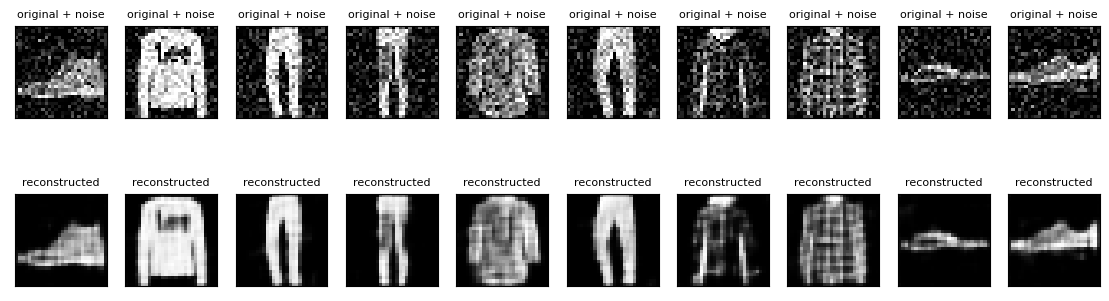

In [14]:
n = 10
plt.figure(figsize=(14, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise", fontsize = 8)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed", fontsize = 8)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

#### My own version of image de-noising:

In [17]:
from tensorflow.keras.models import Sequential


autoencoder = Sequential()

autoencoder.add(layers.Input(shape=(28, 28, 1)))
autoencoder.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, data_format = 'channels_last'))
autoencoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2, data_format = 'channels_last'))
autoencoder.add(layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same', data_format = 'channels_last'))
autoencoder.add(layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same',  data_format = 'channels_last'))
autoencoder.add(layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same',  data_format = 'channels_last'))

autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError())
autoencoder.fit(x_train_noisy, x_train, epochs = 3, shuffle = True, validation_data = (x_test_noisy, x_test))

Epoch 1/3
1875/1875 [==============================] - 121s 64ms/step - loss: 0.0167 - val_loss: 0.0099
Epoch 2/3
1875/1875 [==============================] - 103s 55ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 3/3
1875/1875 [==============================] - 76s 41ms/step - loss: 0.0079 - val_loss: 0.0076


In [20]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 8)        584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-traina

In [18]:
decoded_imgs = autoencoder.predict(new_x_test_noisy)

1/1 [==============================] - 0s 103ms/step


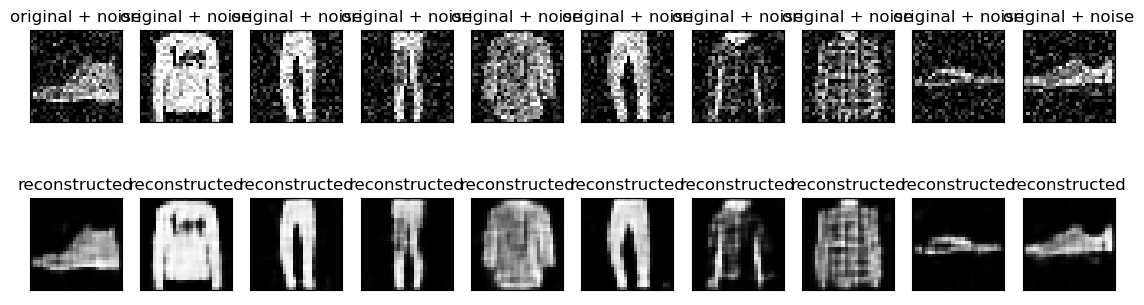

In [19]:
n = 10
plt.figure(figsize=(14, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Keras:

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(16, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

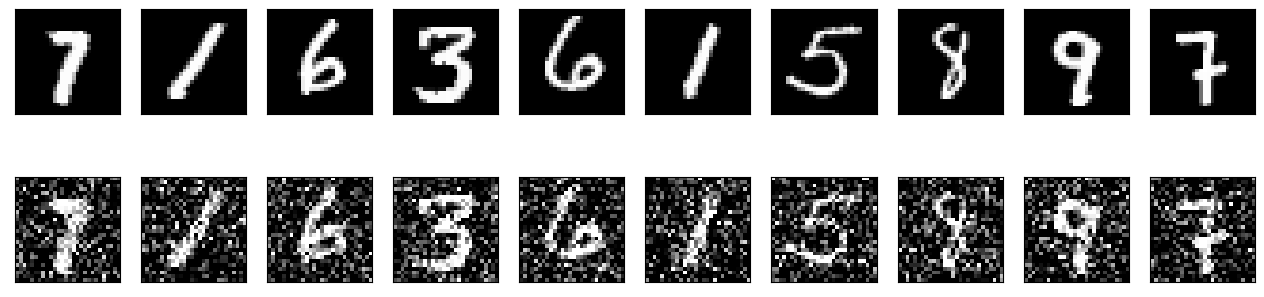

In [7]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [15]:
train_data.shape

(60000, 28, 28, 1)

In [23]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same", data_format = 'channels_last')(input)
x = layers.MaxPooling2D((2, 2), padding="same", data_format = 'channels_last')(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same", data_format = 'channels_last')(x)
x = layers.MaxPooling2D((2, 2), padding="same", data_format = 'channels_last')(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", data_format = 'channels_last')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", data_format = 'channels_last')(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same", data_format = 'channels_last')(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 14, 14, 32)       9248

In [24]:
autoencoder.fit(x = train_data, y = train_data, epochs = 5, batch_size = 32, shuffle = True,
                validation_data = (test_data, test_data),)

Epoch 1/5


2023-03-31 14:52:19.762597: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 151s 80ms/step - loss: 0.0860 - val_loss: 0.0677
Epoch 2/5
1875/1875 [==============================] - 151s 80ms/step - loss: 0.0670 - val_loss: 0.0657
Epoch 3/5
1875/1875 [==============================] - 147s 78ms/step - loss: 0.0655 - val_loss: 0.0647
Epoch 4/5
1875/1875 [==============================] - 152s 81ms/step - loss: 0.0647 - val_loss: 0.0639
Epoch 5/5
1875/1875 [==============================] - 151s 81ms/step - loss: 0.0641 - val_loss: 0.0634


313/313 [==============================] - 6s 18ms/step


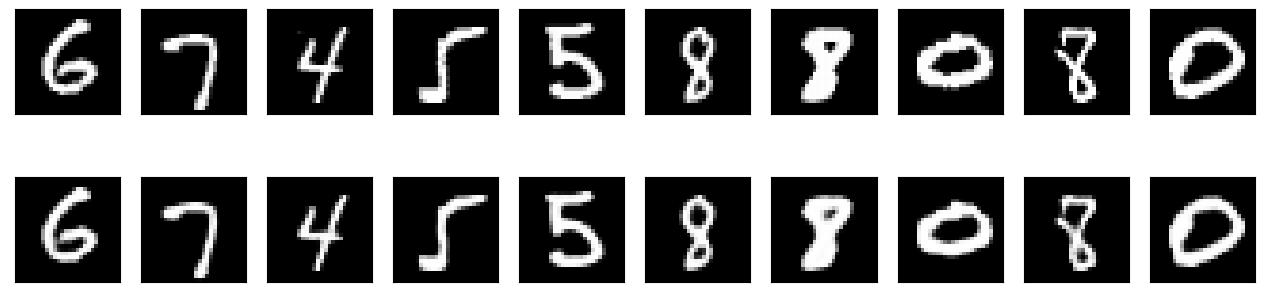

In [25]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [26]:
autoencoder.fit(x = noisy_train_data, y = train_data, epochs = 5, batch_size = 32, shuffle = True, 
                validation_data = (noisy_test_data, test_data),)

Epoch 1/5
1875/1875 [==============================] - 156s 83ms/step - loss: 0.0924 - val_loss: 0.0890
Epoch 2/5
1875/1875 [==============================] - 155s 83ms/step - loss: 0.0884 - val_loss: 0.0870
Epoch 3/5
1875/1875 [==============================] - 152s 81ms/step - loss: 0.0873 - val_loss: 0.0863
Epoch 4/5
1875/1875 [==============================] - 154s 82ms/step - loss: 0.0866 - val_loss: 0.0858
Epoch 5/5
1875/1875 [==============================] - 155s 83ms/step - loss: 0.0862 - val_loss: 0.0860


313/313 [==============================] - 6s 18ms/step


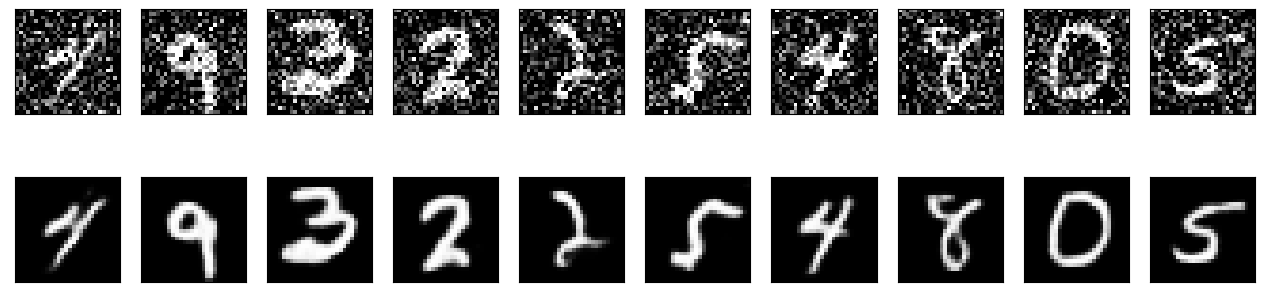

In [27]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)